# Installation

You can install our package from github directly by the following commands:

In [ ]:
if(!require(devtools, quietly = TRUE)){
    install.packages('devtools')
}
devtools::install_github('Tang-RH/sciNMF')

Alternatively, you can download the release package and perform a local installation using the following command:
```
devtools::install_local('the/path/to/package/sciNMF_0.1.1.tar.gz',repos = NULL, type = "source")
```

If there are too many version conflicts among dependent packages, causing the installation failure, we recommend manually installing the following three main dependent packages: `Seurat`, `clusterProfiler`, `GSVA`

# Pipeline for malignant cell states identification

In [ ]:
library(Seurat)
library(sciNMF)

Following are main functions in sciNMF package

In [2]:
ls('package:sciNMF')

[1] "%>%"                "ClusterMetricsPlot" "ClusterPG"         
 [4] "EnrichDotPlot"      "IQRPlot"            "ls_gs_sciNMF"      
 [7] "MetaProgram"        "MPCoxph"            "OverlapMat"        
[10] "PGEnricher"         "RobustProgram"      "RunNMF"

## RunNMF

In [3]:
#load demo Seurat objeect
srt <- readRDS('./Data/DemoSrt.rds')
# 100 maligant cells for 4 individuals
table(srt[['Sample', drop = TRUE]], srt[['CellType', drop = TRUE]])

            
             Malignant
  Ours_AML89       100
  Ours_AML90       100
  Ours_AML93       100
  Ours_AML95       100

<br><br>
The **RunNMF** function conducts non-negative matrix factorization (NMF) analysis on the single-cell gene expression matrix for each individual.

Initially, the count matrices of each individual undergo normalization and scaling. Subsequently, the negative values in the scaled matrices are adjusted to zero. Finally, NMF is performed on the matrices for multiple ranks (from 3 to 8 by default).

The NMF W and H matrices for each individual will be stored in a list object, and then all the lists for individuals will be stored in a higher-level list object.

In [4]:
ls_Demo_WH <- RunNMF(srt, group.by = 'Sample', 
                    dir.output = './DemoResult', # optional, if NULL, the result of pre sample will not be save as .rds file
                    project = 'Demo', # the prefix of result
                    k.range = 3:8, 
                    variable.features.n = 7000,
                    min.cell = 10, 
                    normalization.method = 'SCT',
                    seed = 777)# set a random seed to ensure the reproductivity of result

Start sample Ours_AML89 -- Current time:2023-12-01 14:29:50

Sample Ours_AML89 done!

Start sample Ours_AML90 -- Current time:2023-12-01 14:30:08

Sample Ours_AML90 done!

Start sample Ours_AML93 -- Current time:2023-12-01 14:30:23

Sample Ours_AML93 done!

Start sample Ours_AML95 -- Current time:2023-12-01 14:30:40

Sample Ours_AML95 done!

All Done!



## Robust Programs Identification

Our NMF result of 29 samples from 4 datasets are saved in `Tutorial/Result`, you can load them directly.

In [5]:
ls_ph <- list.files('Result/', full.names = TRUE)
ls_WH <- lapply(ls_ph, readRDS)

**IQRPlot**    
Optional: `IQRPlot` is used to visualize Interquartile Range (IQR) and Median thresholds for filtering out low-quality programs based on within-rank normalized program usage.

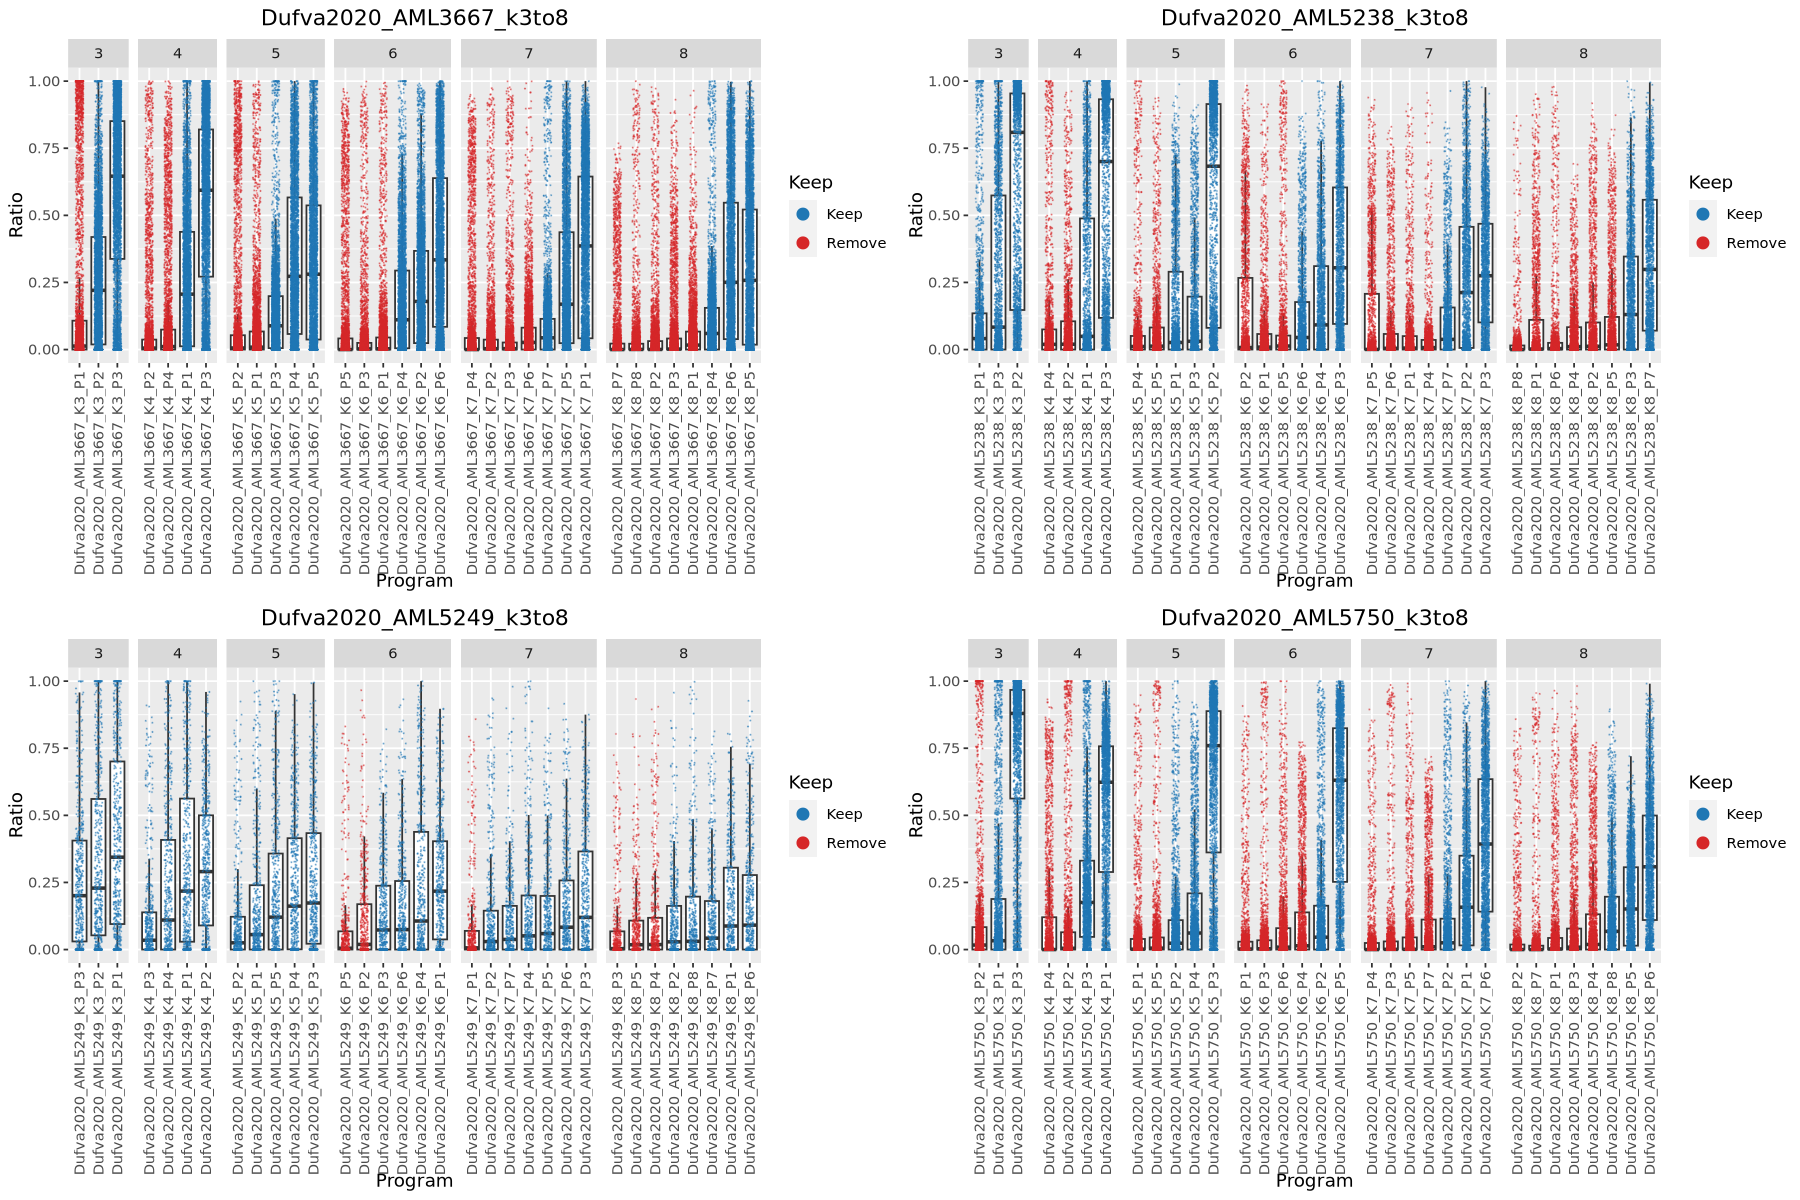

In [6]:
# optional
options(repr.plot.width = 15, repr.plot.height = 10)
IQRPlot(ls_WH[1:4], IQR.cut = 0.1, median.cut = 0.02, grid = TRUE)

**RobustProgram**     
After filtering out programs based on IQR and Median thresholds,  
identify the robust programs based on their intra- and inter-sample reproducibility.

In [7]:
ls_RP <- RobustProgram(WH.list = ls_WH, IQR.cut = 0.1, median.cut = 0.02)
length(ls_RP)

[1] 112

## Meta Program Generation

In [8]:
# calculate the overlap gene counts matrix
ovlp <- OverlapMat(ls_RP)

**ClusterMetricsPlot**    
This function plots metrics across a range of cluster numbers to assist in selecting the optimal cluster number.

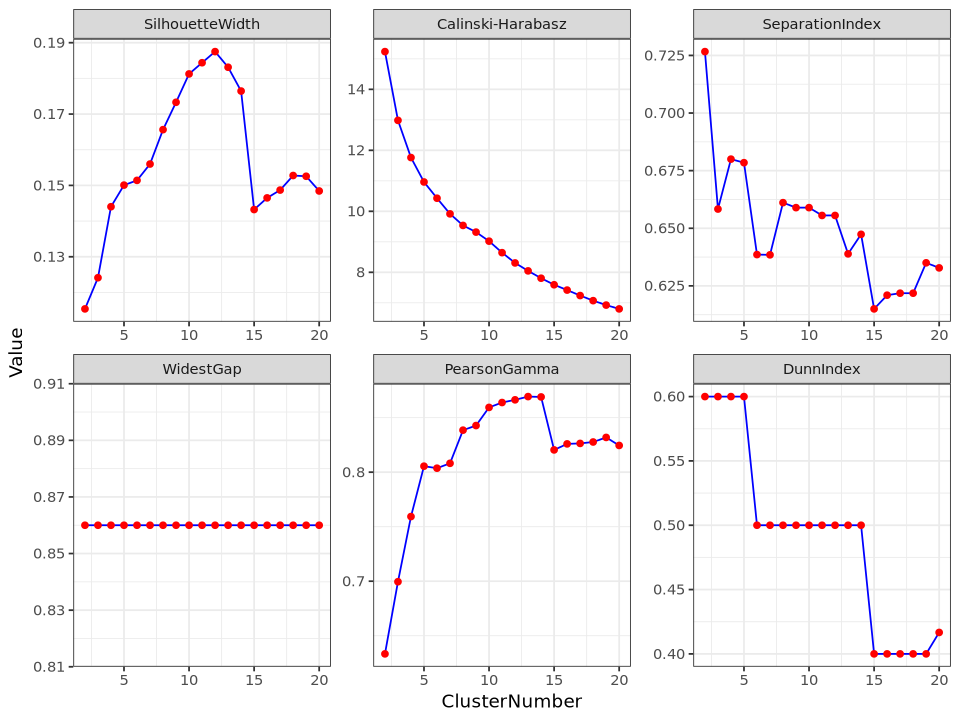

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)
ClusterMetricsPlot(mat.ovlp = ovlp, 
                   distance.clustering = 'Intersection', 
                   max.intersect = 50, 
                   method.clustering = "ward.D2")

**ClusterPG**    
The function clusters the robust programs based on their overlap gene number.

In [10]:
# here we choose the 12 as the cluster number based on highest average silhouette width
res_cluster <- ClusterPG(mat.ovlp = ovlp, cut.num = 12)
table(res_cluster)

res_cluster
 1  2  3  4  5  6  7  8  9 10 11 12 
 9  5  6 10 19  9 13 11 14  7  6  3 

In [11]:
head(res_cluster,3)

Galen2019_AML916D0_K4_P4 Galen2019_AML707BD0_K3_P2 Galen2019_AML921AD0_K4_P1 
                        5                         5                         5

In [12]:
# this step is optional
# create the Sample annotaion data.frame for meta-program heatmap
# you can also constructe your own annotation and color
Sample <- strsplit(names(res_cluster), '_') %>% 
    sapply(function(s){
        paste0(s[1:2],collapse = '_')
})

df_anno <- data.frame(Sample = Sample)
rownames(df_anno) = names(res_cluster)
all_sam <- unique(df_anno$Sample)
col_sam <- setNames(as.character(paletteer::paletteer_d("ggsci::default_igv"))[1:length(all_sam)], all_sam)
ls_col_anno <- list(Sample = col_sam)

In [13]:
# the annotation data.frame
head(df_anno,3)

,Sample
,<chr>
Galen2019_AML916D0_K4_P4,Galen2019_AML916D0
Galen2019_AML707BD0_K3_P2,Galen2019_AML707BD0
Galen2019_AML921AD0_K4_P1,Galen2019_AML921AD0


In [14]:
# the annotation color list
lapply(ls_col_anno, head, 3)

$Sample
 Galen2019_AML916D0 Galen2019_AML707BD0 Galen2019_AML921AD0 
        "#5050FFFF"         "#CE3D32FF"         "#749B58FF"

**MetaProgram**    
Generate the meta programs (MP) based on the cluster result and filter out the meta programs with too manay redundant genes.

The function `MetaProgram` including 3 steps:  
**Step1**: Generate the MP from cluster result. For each MP, the coefficient of genes are calculated from average weight (W matrix of NMF result) of all the programs assigned in this MP and the top genes will be selected as the MP signature.

**Step2**: Remove redundant genes across all MPs, assign the overlap genes by the min rank then max coef across MPs. Then MPs contain no enough genes (`min.size.MP`) are removed.

**Step3**(optional): Draw the heatmap of remaining MPs.

In [15]:
ls_res <- MetaProgram(WH.list = ls_WH, cluster.result = res_cluster,
                     color.mp = rev(as.character(paletteer::paletteer_d(`"RColorBrewer::Set1"`))),
                     show.rownames = FALSE,
                     key = 'Leukemic_S',
                     min.size.MP = 35, keep.rep.gene = TRUE,
                     annotation = df_anno, color.annotation = ls_col_anno) # just ignore the annotation and color.annotation parameters if you don't have addtional annotation

In [16]:
length(ls_res$MetaProgram)

[1] 9

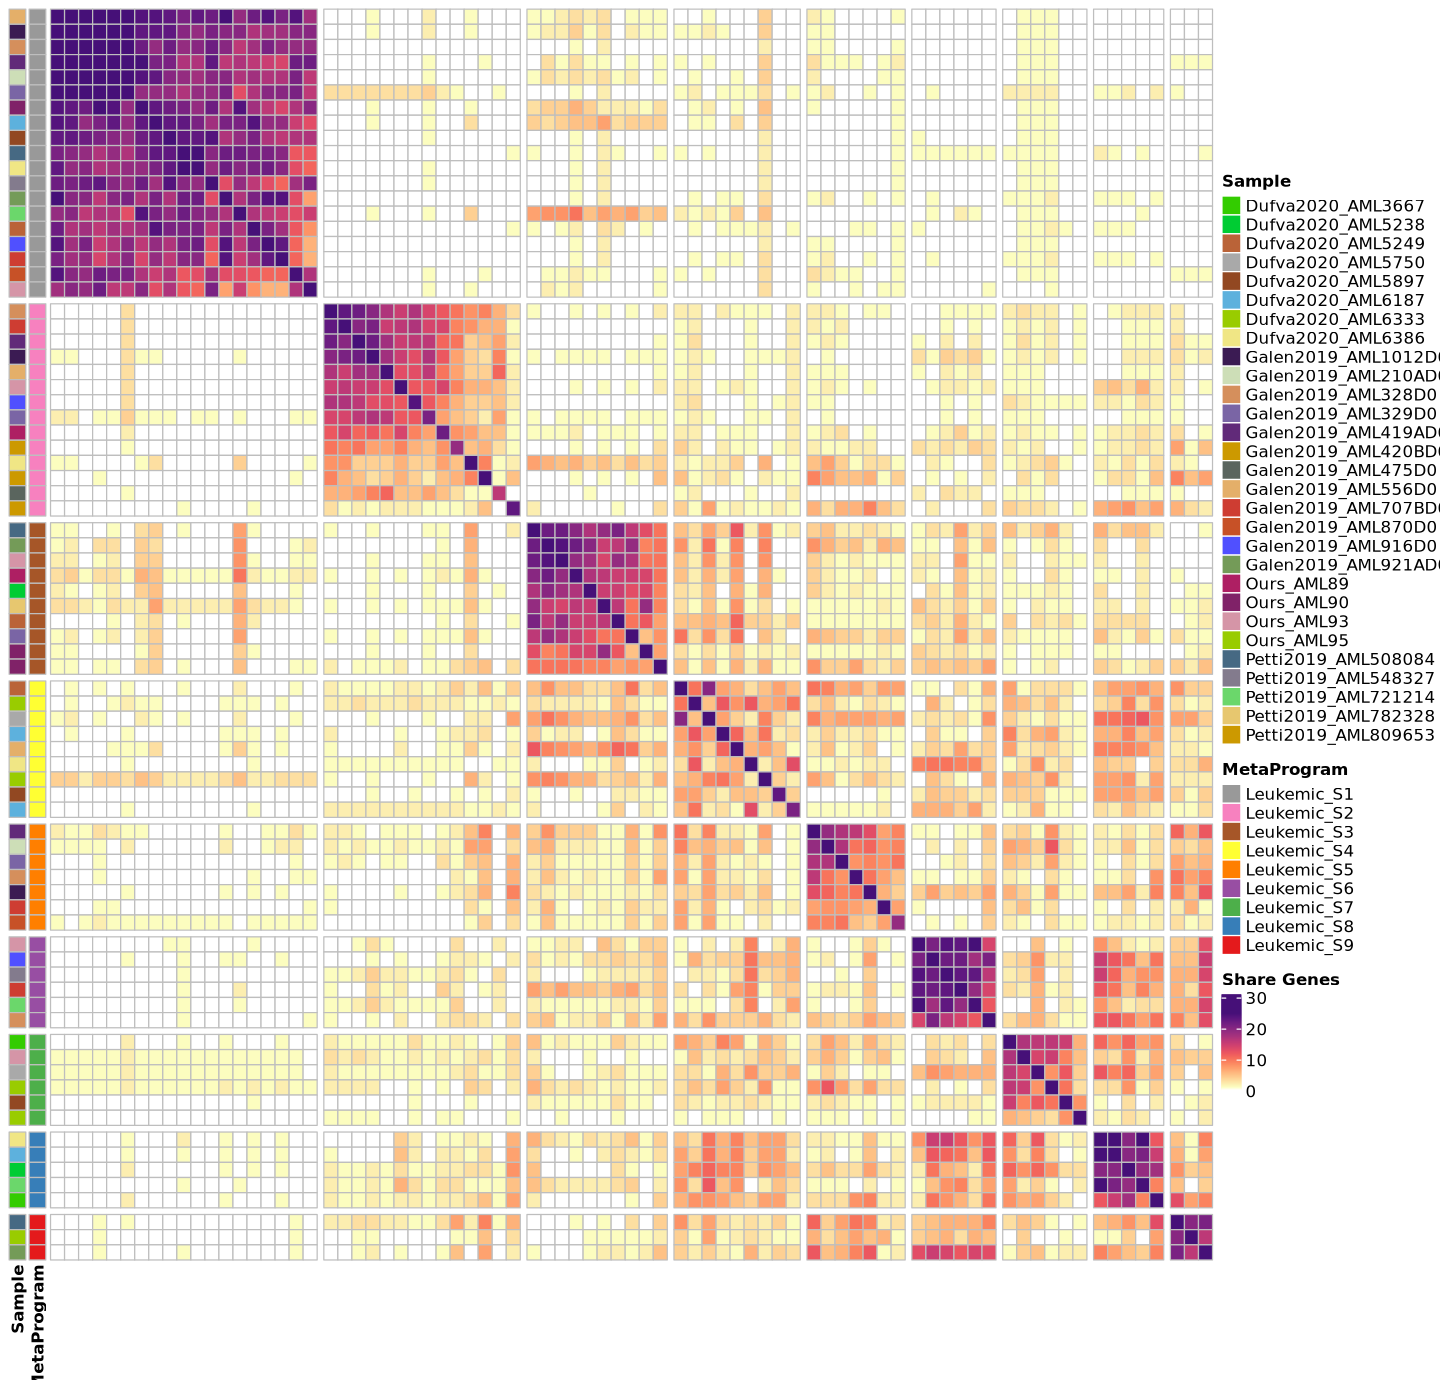

In [17]:
options(repr.plot.width = 12, repr.plot.height = 11.5)
ls_res$HeatMap

In [18]:
# save the plot
dir.create('Figure')
pdf('Figure/HeatMap.pdf', width = 12, height = 11.5)
print(ls_res$HeatMap)
dev.off()

png 
  2

In [19]:
ls_MP <- ls_res$MetaProgram
sapply(ls_MP,head,5)

Leukemic_S1,Leukemic_S2,Leukemic_S3,Leukemic_S4,Leukemic_S5,Leukemic_S6,Leukemic_S7,Leukemic_S8,Leukemic_S9
TUBA1B,MALAT1,AZU1,FTH1,SPINK2,CRIP1,SLC40A1,FOS,JCHAIN
STMN1,NEAT1,SRGN,TPM4,CDK6,VIM,SOX4,CXCL8,CD36
H2AFZ,NKTR,MPO,H1FX,ANGPT1,S100A10,GATA2,DUSP1,SPINK2
TUBB,LUC7L3,CTSG,DDIT3,SERPINB1,LGALS1,CNRIP1,JUN,CD99
HIST1H4C,PNISR,LYZ,GNA15,SOX4,TAGLN2,PLEK,EGR1,CD34


## Cell State Annotation

In [20]:
# generate the universe genes
all_gene <- lapply(ls_WH, function(WH){
    rownames(WH$W)
}) %>% Reduce(f = union)
length(all_gene)

[1] 14650

**PGEnricher**  
Perfrom enrichment analysis based on hypergeometric test. 5 build-in gene sets are `Hallmark`, `GO_BP`, `GO_CC`, `GO_MF`, `CellMarker`.

In [21]:
ls_enrich_GO <- PGEnricher(ls_MP, gene.set = c('GO_BP','GO_CC','GO_MF'), universe = all_gene)

In [22]:
# the enrichment data.frames for each MP are stored in a list object
head(ls_enrich_GO[[1]], 3)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Chromosome (GO:0005694),Chromosome (GO:0005694),Chromosome (GO:0005694),8/45,140/11940,4.369812e-08,1.370134e-05,9.862606e-06,HMGB2/HMGB1/TOP2A/MKI67/BIRC5/BRCA1/SMC2/RAD51AP1,8
DNA Metabolic Process (GO:0006259),DNA Metabolic Process (GO:0006259),DNA Metabolic Process (GO:0006259),10/45,271/11940,4.867260e-08,1.370134e-05,9.862606e-06,HMGB2/HMGB1/DUT/TOP2A/TYMS/MCM4/MCM7/BRCA1/RAD51AP1/RRM1,10
Chromosome Condensation (GO:0030261),Chromosome Condensation (GO:0030261),Chromosome Condensation (GO:0030261),4/45,20/11940,8.161368e-07,1.050443e-04,7.561381e-05,TOP2A/NUSAP1/SMC2/SMC4,4


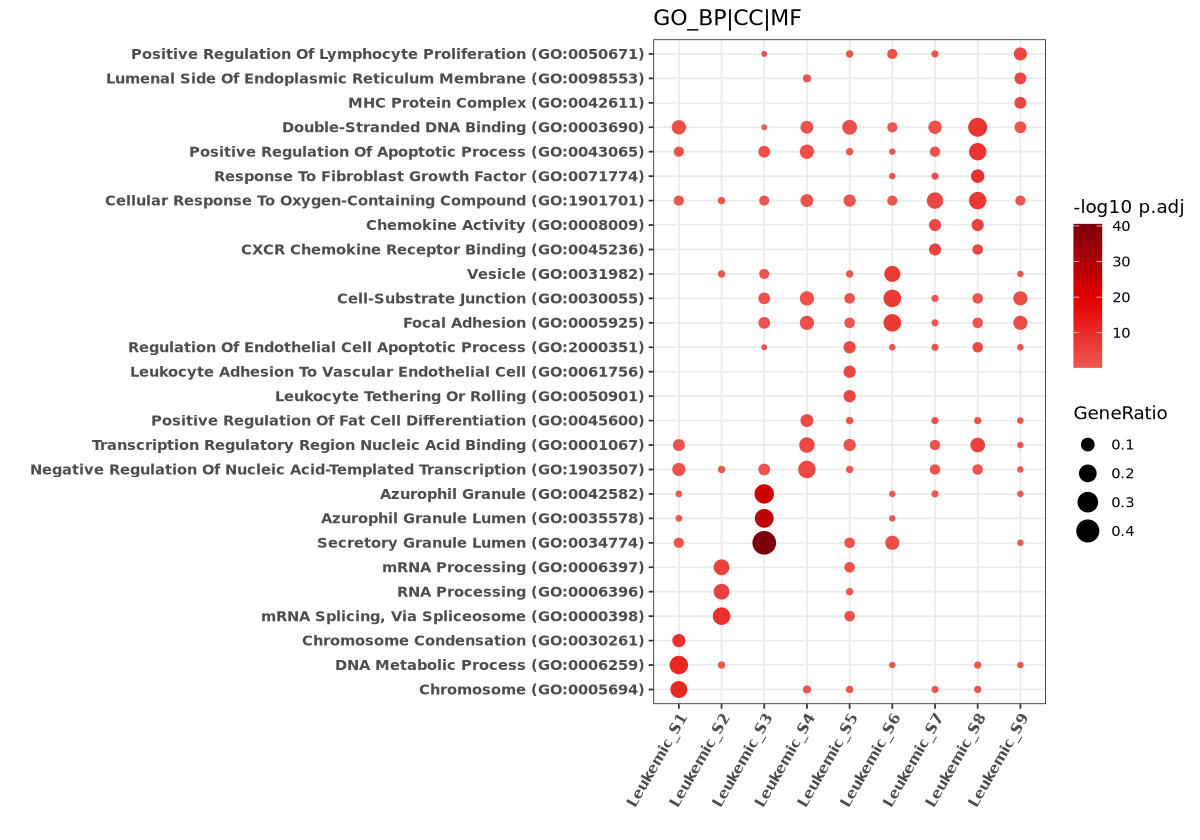

In [23]:
options(repr.plot.width = 10, repr.plot.height = 7)
pl <- EnrichDotPlot(ls_enrich_GO,only.top = FALSE, title = 'GO_BP|CC|MF')
ggplot2::ggsave('Figure/GO_EnrichDotPlot.png', pl, width = 10, height = 7)
pl

## Prognosis Value of MP

**MPCoxph**  
This function provides a quick assessment of the prognostic value of MPs within each subgroup of patients. The MP scores are calculated using 'ssGSEA' in `GSVA::gsva` by default.

In [24]:
# use the TCGA-LAML data as example
bulk <- read.table('Data/TCGA_LAML_lg1ptpm.txt')
cli <- read.table('Data/TCGA_LAML_clinical.txt')
head(cli, 3)

,OS.time,OS.status,SEX,FAB,AGE,CYTOGENETICS,CytogeneticRsik,HISTOLOGICAL_SUBTYPE,RISK_MOLECULAR
,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
TCGA.AB.2803,25.7,1,Female,M3,61,"46,XX,t(15;17)(q22:q21)[15]",Good,PML-RARA,Good
TCGA.AB.2805,18.5,1,Male,M0,77,"46, XY[20]",Intermediate,Normal Karyotype,Intermediate
TCGA.AB.2806,30.6,1,Male,M1,46,"45,X,-Y, t(8;7;21)(q22;p15;q22[22]/46,XY[3]",Good,RUNX1-RUNX1T1,Good


Calculating scores for Group Female 


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message in .filterFeatures(expr, method):
“203 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 9 gene sets.
[1] "Calculating ranks..."


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
Calculating scores for Group Male 


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message in .filterFeatures(expr, method):
“86 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 9 gene sets.
[1] "Calculating ranks..."


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


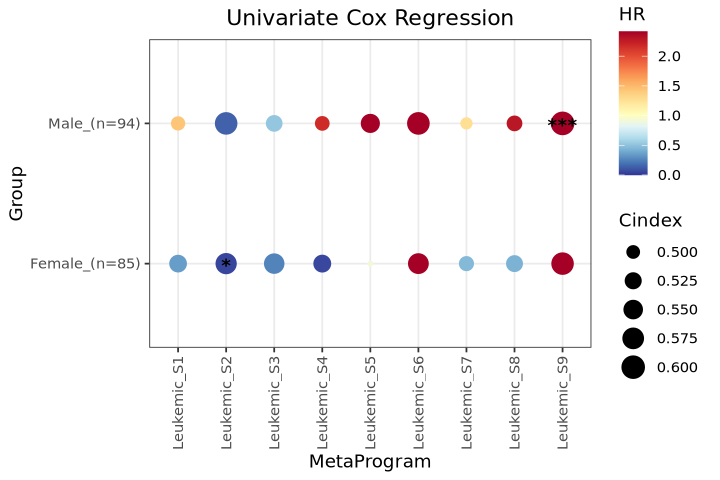

In [25]:
options(repr.plot.width = 6, repr.plot.height = 4)
pl <- MPCoxph(mat.exp = bulk, cli = cli, gene.list = ls_MP, return.df = FALSE,
             group.by = 'SEX', color.asterisks = 'black')
ggplot2::ggsave('Figure/MPCoxph.png', pl, width = 6, height = 4)
pl

In [26]:
# you can get the original result from the ggplot object
head(pl$data, 3)

,Group,Signature,Cindex,HR,pvalue,Significance,GroupName,GroupSize,TrueHR
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>
1,Male_(n=94),Leukemic_S9,0.6013054,2.4157405,0.0001371572,***,Male,94,35.0890661
2,Male_(n=94),Leukemic_S6,0.5871634,2.4157405,0.0926681901,,Male,94,7.5865912
3,Male_(n=94),Leukemic_S2,0.5863476,0.1420456,0.1237421597,,Male,94,0.1420456


# System infomation

In [27]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cluster2/huanglab/rtang/conda/envs/R4.2/lib/libopenblasp-r0.3.25.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] sciNMF_0.1.1       Seurat_5.0.1       SeuratObject_5.0.1 sp_2.1-2          

loaded via a namespace (and not attached):
  [1] pbdZMQ_0.3-10               scattermore_1.2            
  [3] prabclus_2.3-3              ragg_1.2.6                 
  [5] tidyr_1.3.0                 ggplot2_3.4.4 